In [122]:
import pandas as pd
import duckdb as db
import os
import glob
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
#from pretty_confusion_matrix import pp_matrix
from matplotlib.collections import QuadMesh
import matplotlib.font_manager as fm

In [27]:
df = pd.read_csv('all_matches.csv')
df

,match_id,home_team,away_team,t1_t1_entropy,t2_t2_entropy,t1_t2_entropy,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI
0,15946,Barcelona,Deportivo Alavés,6.884968,1.652269,1.232094,1.135241,10.904572,0.622502,0.160403,0.462099
1,15956,Real Valladolid,Barcelona,3.469568,4.994467,0.831541,1.223273,10.518850,0.367084,0.437570,-0.070486
2,15973,Barcelona,Huesca,6.008893,2.535022,0.959982,1.002560,10.506456,0.575976,0.237230,0.338747
3,15978,Real Sociedad,Barcelona,2.768963,5.638493,1.154647,1.067252,10.629355,0.252279,0.538686,-0.286407
4,15986,Barcelona,Girona,5.822328,2.798942,1.165969,1.036201,10.823440,0.525947,0.270590,0.255358
...,...,...,...,...,...,...,...,...,...,...,...
692,9889,Celta Vigo,Barcelona,4.215248,4.135289,0.947568,1.099771,10.397876,0.420033,0.383067,0.036966
693,9912,RC Deportivo La Coruña,Barcelona,3.552477,5.214002,0.692081,0.937694,10.396254,0.365333,0.477902,-0.112569
694,9924,Barcelona,Real Madrid,4.129355,4.326729,1.198815,1.061504,10.716403,0.372517,0.416561,-0.044044
695,9928,Barcelona,Villarreal,4.647487,3.930977,1.112722,1.156754,10.847940,0.432480,0.358312,0.074168


In [28]:
drop_columns = ['match_date', 'kick_off', 'match_status', 'match_status_360', 'last_updated', \
                'last_updated_360', 'metadata', 'competition_stage', 'stadium', 'referee', 'match_week']

In [29]:
df_list = []
for i in glob.glob('data\matches\*'):
    for m in glob.glob(i+'\*'):
        print(m)
        df = pd.read_json(m)
        df['home_team'] = df['home_team'].astype('str')
        df['home_team'] = df['home_team'].str.split(':').str[2].str.split(',').str[0].str.replace("'", '')
        df['away_team'] = df['away_team'].astype('str')
        df['away_team'] = df['away_team'].str.split(':').str[2].str.split(',').str[0].str.replace("'", '')
        df['competition'] = df['competition'].astype('str')
        df['competition'] = df['competition'].str.split(':').str[3].str.replace("'", '').str.replace("}", '', regex=True)
        df['season'] = df['season'].astype('str')
        df['season'] = df['season'].str.split(':').str[2].str.replace("'", '').str.replace("}", '', regex=True)
        df = df.drop(columns=drop_columns, errors='ignore')
        df['home_win'] = 0
        df['away_win'] = 0
        df['tie'] = 0
        df.loc[df['home_score'] > df['away_score'], 'home_win'] = 1
        df.loc[df['away_score'] > df['home_score'], 'away_win'] = 1
        df.loc[df['away_score'] == df['home_score'], 'tie'] = 1
        df_list.append(df)
        
df_full = pd.concat(df_list)
df_full

data\matches\11\1.json
data\matches\11\2.json
data\matches\11\21.json
data\matches\11\22.json
data\matches\11\23.json
data\matches\11\24.json
data\matches\11\25.json
data\matches\11\26.json
data\matches\11\27.json
data\matches\11\37.json
data\matches\11\38.json
data\matches\11\39.json
data\matches\11\4.json
data\matches\11\40.json
data\matches\11\41.json
data\matches\11\42.json
data\matches\11\90.json
data\matches\1238\108.json
data\matches\16\1.json
data\matches\16\2.json
data\matches\16\21.json
data\matches\16\22.json
data\matches\16\23.json
data\matches\16\24.json
data\matches\16\25.json
data\matches\16\26.json
data\matches\16\27.json
data\matches\16\37.json
data\matches\16\39.json
data\matches\16\4.json
data\matches\16\41.json
data\matches\16\44.json
data\matches\2\44.json


,match_id,competition,season,home_team,away_team,home_score,away_score,home_win,away_win,tie
0,9880,La Liga,2017/2018,Barcelona,Valencia,2,1,1,0,0
1,9912,La Liga,2017/2018,RC Deportivo La Coruña,Barcelona,2,4,0,1,0
2,9924,La Liga,2017/2018,Barcelona,Real Madrid,2,2,0,0,1
3,9855,La Liga,2017/2018,Barcelona,Athletic Club,2,0,1,0,0
4,9827,La Liga,2017/2018,Las Palmas,Barcelona,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
33,3749108,Premier League,2003/2004,Arsenal,Aston Villa,2,0,1,0,0
34,3749153,Premier League,2003/2004,Arsenal,Middlesbrough,4,1,1,0,0
35,3749403,Premier League,2003/2004,Arsenal,Bolton Wanderers,2,1,1,0,0
36,3749526,Premier League,2003/2004,Charlton Athletic,Arsenal,1,1,0,0,1


In [30]:
all_matches = pd.read_csv('all_matches.csv')
all_matches

,match_id,home_team,away_team,t1_t1_entropy,t2_t2_entropy,t1_t2_entropy,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI
0,15946,Barcelona,Deportivo Alavés,6.884968,1.652269,1.232094,1.135241,10.904572,0.622502,0.160403,0.462099
1,15956,Real Valladolid,Barcelona,3.469568,4.994467,0.831541,1.223273,10.518850,0.367084,0.437570,-0.070486
2,15973,Barcelona,Huesca,6.008893,2.535022,0.959982,1.002560,10.506456,0.575976,0.237230,0.338747
3,15978,Real Sociedad,Barcelona,2.768963,5.638493,1.154647,1.067252,10.629355,0.252279,0.538686,-0.286407
4,15986,Barcelona,Girona,5.822328,2.798942,1.165969,1.036201,10.823440,0.525947,0.270590,0.255358
...,...,...,...,...,...,...,...,...,...,...,...
692,9889,Celta Vigo,Barcelona,4.215248,4.135289,0.947568,1.099771,10.397876,0.420033,0.383067,0.036966
693,9912,RC Deportivo La Coruña,Barcelona,3.552477,5.214002,0.692081,0.937694,10.396254,0.365333,0.477902,-0.112569
694,9924,Barcelona,Real Madrid,4.129355,4.326729,1.198815,1.061504,10.716403,0.372517,0.416561,-0.044044
695,9928,Barcelona,Villarreal,4.647487,3.930977,1.112722,1.156754,10.847940,0.432480,0.358312,0.074168


In [31]:
df_comb = db.query('''select * from df_full f inner join all_matches a on f.match_id=a.match_id''').df()
df_comb

,match_id,competition,season,home_team,away_team,home_score,away_score,home_win,away_win,tie,...,home_team_2,away_team_2,t1_t1_entropy,t2_t2_entropy,t1_t2_entropy,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI
0,15946,La Liga,2018/2019,Barcelona,Deportivo Alavés,3,0,1,0,0,...,Barcelona,Deportivo Alavés,6.884968,1.652269,1.232094,1.135241,10.904572,0.622502,0.160403,0.462099
1,15956,La Liga,2018/2019,Real Valladolid,Barcelona,0,1,0,1,0,...,Real Valladolid,Barcelona,3.469568,4.994467,0.831541,1.223273,10.518850,0.367084,0.437570,-0.070486
2,15973,La Liga,2018/2019,Barcelona,Huesca,8,2,1,0,0,...,Barcelona,Huesca,6.008893,2.535022,0.959982,1.002560,10.506456,0.575976,0.237230,0.338747
3,15978,La Liga,2018/2019,Real Sociedad,Barcelona,1,2,0,1,0,...,Real Sociedad,Barcelona,2.768963,5.638493,1.154647,1.067252,10.629355,0.252279,0.538686,-0.286407
4,15986,La Liga,2018/2019,Barcelona,Girona,2,2,0,0,1,...,Barcelona,Girona,5.822328,2.798942,1.165969,1.036201,10.823440,0.525947,0.270590,0.255358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,9700,La Liga,2017/2018,Barcelona,Celta Vigo,2,2,0,0,1,...,Barcelona,Celta Vigo,5.502583,2.924616,1.417909,1.197818,11.042926,0.478360,0.284771,0.193589
683,266952,La Liga,2016/2017,Barcelona,Villarreal,4,1,1,0,0,...,Barcelona,Villarreal,5.298429,2.678190,1.585246,1.313722,10.875586,0.462219,0.271223,0.190996
684,267561,La Liga,2014/2015,Rayo Vallecano,Barcelona,0,2,0,1,0,...,Rayo Vallecano,Barcelona,3.190862,4.711522,1.276957,1.137066,10.316407,0.295740,0.470262,-0.174522
685,69243,La Liga,2009/2010,Barcelona,Sevilla,4,0,1,0,0,...,Barcelona,Sevilla,5.713168,2.247884,1.437068,1.291852,10.689972,0.520858,0.223864,0.296994


In [32]:
db.query('''select count(*) as correct_home from df_comb where home_win = 1 and SEI > 0''').df()

,correct_home
0,256


In [33]:
db.query('''select count(*) as correct_away from df_comb where away_win = 1 and SEI < 0''').df()

,correct_away
0,191


In [34]:
db.query('''select count(*) as non_ties from df_comb where tie <> 1''').df()

,non_ties
0,553


In [35]:
print((256+191)/553)

0.8083182640144665


In [36]:
print((256+191)/687)

0.6506550218340611


In [163]:
df_complete=db.query('''select *, case when SEI > 0 then 1 when SEI < 0 then 0 end as Home_Win_Pred,
case when SEI > 0 then 0 when SEI < 0 then 1 end as away_Win_Pred
from df_comb''').df()
df_complete.to_csv('Full_match_outcome.csv')

In [150]:
df_complete_tie=db.query('''select *, case when SEI > .05 then 1 when SEI < -.05 then 0 else 0 end as Home_Win_Pred,
case when SEI > .05 then 0 when SEI < -.05 then 1 else 0 end as away_Win_Pred,
case when SEI <= .05 and SEI >= -.05 then 1 else 0 end as tie_Pred,
case when home_win=1 then 1 when away_win=1 then 0 when tie=1 then 2 end as actual,
case when SEI>.05 then 1 when SEI<-.05 then 0 else 2 end as Pred
from df_comb''').df()
df_complete_tie

,match_id,competition,season,home_team,away_team,home_score,away_score,home_win,away_win,tie,...,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI,Home_Win_Pred,away_Win_Pred,tie_Pred,actual,Pred
0,15946,La Liga,2018/2019,Barcelona,Deportivo Alavés,3,0,1,0,0,...,1.135241,10.904572,0.622502,0.160403,0.462099,1,0,0,1,1
1,15956,La Liga,2018/2019,Real Valladolid,Barcelona,0,1,0,1,0,...,1.223273,10.518850,0.367084,0.437570,-0.070486,0,1,0,0,0
2,15973,La Liga,2018/2019,Barcelona,Huesca,8,2,1,0,0,...,1.002560,10.506456,0.575976,0.237230,0.338747,1,0,0,1,1
3,15978,La Liga,2018/2019,Real Sociedad,Barcelona,1,2,0,1,0,...,1.067252,10.629355,0.252279,0.538686,-0.286407,0,1,0,0,0
4,15986,La Liga,2018/2019,Barcelona,Girona,2,2,0,0,1,...,1.036201,10.823440,0.525947,0.270590,0.255358,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,9700,La Liga,2017/2018,Barcelona,Celta Vigo,2,2,0,0,1,...,1.197818,11.042926,0.478360,0.284771,0.193589,1,0,0,2,1
683,266952,La Liga,2016/2017,Barcelona,Villarreal,4,1,1,0,0,...,1.313722,10.875586,0.462219,0.271223,0.190996,1,0,0,1,1
684,267561,La Liga,2014/2015,Rayo Vallecano,Barcelona,0,2,0,1,0,...,1.137066,10.316407,0.295740,0.470262,-0.174522,0,1,0,0,0
685,69243,La Liga,2009/2010,Barcelona,Sevilla,4,0,1,0,0,...,1.291852,10.689972,0.520858,0.223864,0.296994,1,0,0,1,1


In [145]:
db.query('''select * from df_complete_tie where tie=1 and tie_Pred=0''').df()

,match_id,competition,season,home_team,away_team,home_score,away_score,home_win,away_win,tie,...,t2_t2_entropy,t1_t2_entropy,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI,Home_Win_Pred,away_Win_Pred,tie_Pred
0,15986,La Liga,2018/2019,Barcelona,Girona,2,2,0,0,1,...,2.798942,1.165969,1.036201,10.823440,0.525947,0.270590,0.255358,1,0,0
1,16010,La Liga,2018/2019,Barcelona,Athletic Club,1,1,0,0,1,...,2.315134,1.679490,1.527143,10.836806,0.476403,0.227695,0.248709,1,0,0
2,16073,La Liga,2018/2019,Atlético Madrid,Barcelona,1,1,0,0,1,...,5.449714,1.201389,1.092458,10.479221,0.250661,0.530444,-0.279784,0,1,0
3,16157,La Liga,2018/2019,Barcelona,Valencia,2,2,0,0,1,...,3.028569,1.198640,0.883261,10.973309,0.505541,0.304735,0.200807,1,0,0
4,16240,La Liga,2018/2019,Villarreal,Barcelona,4,4,0,0,1,...,5.480951,0.963146,1.069517,10.575912,0.299612,0.508191,-0.208579,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,70282,La Liga,2012/2013,Valencia,Barcelona,1,1,0,0,1,...,4.899462,1.140748,1.184589,10.472051,0.314274,0.463674,-0.149400,0,1,0
110,9695,La Liga,2017/2018,Valencia,Barcelona,1,1,0,0,1,...,5.375148,1.103764,1.314034,10.567882,0.282479,0.488733,-0.206254,0,1,0
111,9783,La Liga,2017/2018,Espanyol,Barcelona,1,1,0,0,1,...,5.048748,1.473729,1.519500,10.296364,0.223395,0.485897,-0.262502,0,1,0
112,266256,La Liga,2013/2014,Barcelona,Atlético Madrid,1,1,0,0,1,...,2.543656,2.173044,1.946905,11.038464,0.375842,0.250922,0.124920,1,0,0


In [198]:
df_complete_no_ties=db.query('''select *, case when SEI > 0 then 1 when SEI < 0 then 0 end as Home_Win_Pred,
case when SEI > 0 then 0 when SEI < 0 then 1 end as away_Win_Pred
from df_comb where tie=0''').df()

In [82]:
cm = metrics.confusion_matrix(df_complete.home_win, df_complete.Home_Win_Pred, labels= [1,0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual Loss'], index=['Predicted Win', 'Predicted Loss'])
df_cm

,Actual Win,Actual Loss
Predicted Win,256,62
Predicted Loss,98,271


In [83]:
print('Predicted 0, Actual 0\n',db.query('''select count(*) from df_complete where home_win = 0 and Home_Win_Pred = 0'''))
print('Predicted 1, Actual 0\n',db.query('''select count(*) from df_complete where home_win = 0 and Home_Win_Pred = 1'''))
print('Predicted 1, Actual 1\n',db.query('''select count(*) from df_complete where home_win = 1 and Home_Win_Pred = 1'''))
print('Predicted 0, Actual 1\n',db.query('''select count(*) from df_complete where home_win = 1 and Home_Win_Pred = 0'''))

Predicted 0, Actual 0
 ┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          271 │
└──────────────┘

Predicted 1, Actual 0
 ┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           98 │
└──────────────┘

Predicted 1, Actual 1
 ┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          256 │
└──────────────┘

Predicted 0, Actual 1
 ┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           62 │
└──────────────┘



In [196]:
def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1

def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col
    
def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()
    fig.savefig("out_no_tie.png") 

C:\Users\jacks\AppData\Local\Temp\ipykernel_11464\1744079634.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


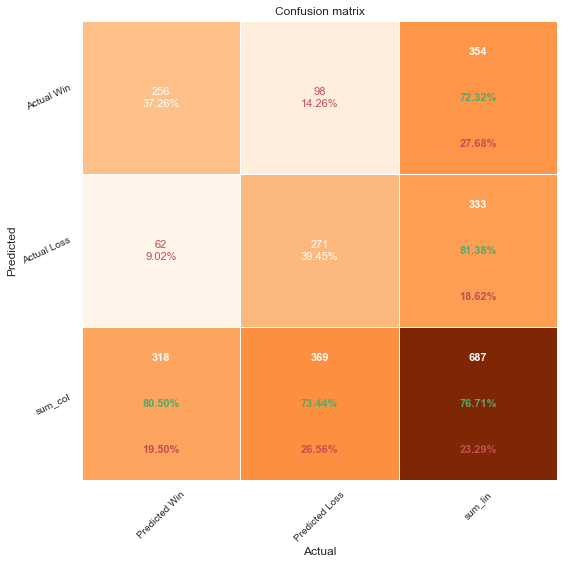

In [197]:
matrix = pp_matrix(df_cm) #viridis, Greys, Blues, Oranges

In [134]:
matrix.savefig("out.png") 

C:\Users\jacks\AppData\Local\Temp\ipykernel_11464\3462470606.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


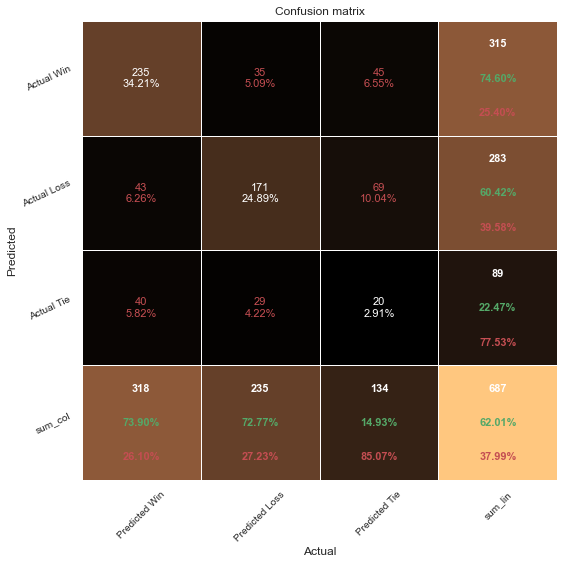

In [195]:
cm_tie = metrics.confusion_matrix(df_complete_tie.actual, df_complete_tie.Pred, labels=[1,0,2])
df_cm_tie = pd.DataFrame(cm_tie,  columns=['Actual Win','Actual Loss', 'Actual Tie'], index=['Predicted Win', 'Predicted Loss', 'Predicted Tie'])
df_cm_tie
pp_matrix(df_cm_tie,cmap='copper') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_11464\1744079634.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


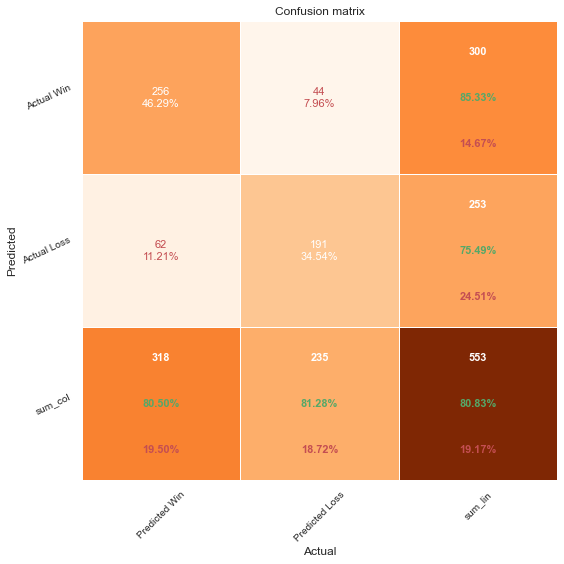

In [199]:
cm_n_tie = metrics.confusion_matrix(df_complete_no_ties.home_win, df_complete_no_ties.Home_Win_Pred, labels= [1,0])
df_cm_n_tie = pd.DataFrame(cm_n_tie,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
matrix = pp_matrix(df_cm_n_tie)